In [31]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import pickle

In [32]:
test_data = pd.read_csv("/media/datasets/rna-folding/test_sequences.csv")

In [33]:
from torch.utils.data import Dataset, DataLoader

class RNADataset(Dataset):
    def __init__(self,data):
        self.data=data
        self.tokens={nt:i for i,nt in enumerate('ACGU')}

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sequence=[self.tokens[nt] for nt in (self.data.loc[idx,'sequence'])]
        sequence=np.array(sequence)
        sequence=torch.tensor(sequence)

        return {'sequence':sequence}

In [34]:
test_dataset=RNADataset(test_data)
test_dataset[0]

{'sequence': tensor([2, 2, 2, 2, 2, 1, 1, 0, 1, 0, 2, 1, 0, 2, 0, 0, 2, 1, 2, 3, 3, 1, 0, 1,
         2, 3, 1, 2, 1, 0, 2, 1, 1, 1, 1, 3, 2, 3, 1, 0, 2, 1, 1, 0, 3, 3, 2, 1,
         0, 1, 3, 1, 1, 2, 2, 1, 3, 2, 1, 2, 0, 0, 3, 3, 1, 3, 2, 1, 3])}

In [35]:
from Network import *
import yaml


class Config:
    def __init__(self, **entries):
        self.__dict__.update(entries)
        self.entries=entries

    def print(self):
        print(self.entries)


def load_config_from_yaml(file_path):
    with open(file_path, 'r') as file:
        config = yaml.safe_load(file)
    return Config(**config)


class finetuned_RibonanzaNet(RibonanzaNet):
    def __init__(self, config, pretrained=False):
        config.dropout=0.2
        super(finetuned_RibonanzaNet, self).__init__(config)
        if pretrained:
            self.load_state_dict(torch.load("RibonanzaNet.pt",map_location='cpu'))
        self.dropout=nn.Dropout(0.0)
        self.xyz_predictor=nn.Linear(256,3)

    def forward(self,src):
        sequence_features, pairwise_features=self.get_embeddings(src, torch.ones_like(src).long().to(src.device))

        xyz=self.xyz_predictor(sequence_features)

        return xyz

In [36]:
model=finetuned_RibonanzaNet(load_config_from_yaml("pairwise.yaml"),pretrained=False).cuda()

model.load_state_dict(torch.load("RibonanzaNet-3D.pt"))

constructing 9 ConvTransformerEncoderLayers


<All keys matched successfully>

In [37]:
test_dataset[0]['sequence'].shape

torch.Size([69])

In [38]:
model.eval()
preds=[]

for i in range(len(test_dataset)):
    src=test_dataset[i]['sequence'].long()
    src=src.unsqueeze(0).cuda()

    model.train()

    tmp=[]
    for i in range(4):
        with torch.no_grad():
            xyz=model(src).squeeze()
        tmp.append(xyz.cpu().numpy())

    model.eval()
    with torch.no_grad():
        xyz=model(src).squeeze()
    tmp.append(xyz.cpu().numpy())

    tmp=np.stack(tmp,0)
    preds.append(tmp)

/home/morgan/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning:

torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.

/home/morgan/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning:

None of the inputs have requires_grad=True. Gradients will be None



In [39]:
tmp.shape

(5, 118, 3)

In [40]:
preds[0]

array([[[ 2.00264683e+01, -4.37273622e-01,  2.77946615e+00],
        [ 2.13922195e+01,  3.60151672e+00,  9.80558300e+00],
        [ 1.56903982e+01,  2.20658278e+00,  1.38413229e+01],
        ...,
        [ 3.95827830e-01,  1.35578270e+01,  1.89811363e+01],
        [ 5.67727327e-01,  1.25241022e+01,  1.90050259e+01],
        [ 7.49183607e+00,  1.30837402e+01,  1.52220621e+01]],

       [[ 1.93886623e+01,  8.56317878e-01,  2.41931558e+00],
        [ 2.49918385e+01, -7.02956021e-01,  7.26442909e+00],
        [ 1.88548584e+01,  3.09278274e+00,  1.23113947e+01],
        ...,
        [-2.26462650e+00,  2.79769077e+01,  1.89989491e+01],
        [ 1.61943448e+00,  2.92184544e+01,  2.44444618e+01],
        [ 7.75969648e+00,  2.07775345e+01,  1.89139938e+01]],

       [[ 2.45794678e+01,  1.50496626e+00,  3.96917009e+00],
        [ 2.15163841e+01,  1.04404354e+00,  7.04745865e+00],
        [ 2.14290695e+01,  8.76615942e-03,  8.70255184e+00],
        ...,
        [-3.45241356e+00,  1.96259518e+01,

In [41]:
preds[7][0].shape

(720, 3)

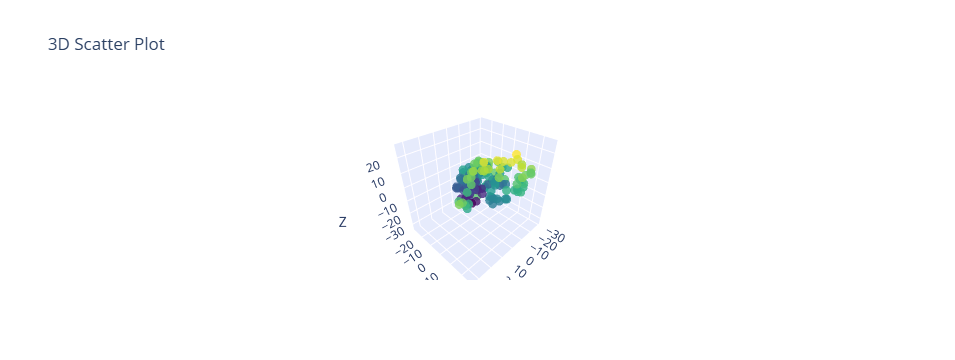

In [42]:
import plotly.graph_objects as go
import numpy as np

# Example: Generate an Nx3 matrix

xyz = preds[2][0]

x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]

fig = go.Figure(data=[go.Scatter3d(
    x=x, y=y, z=z,
    mode='markers',
    marker=dict(
        size=5,
        color=z,
        colorscale='Viridis',
        opacity=0.8
    )
)])


fig.update_layout(
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z"
    ),
    title="3D Scatter Plot"
)

fig.show()

In [43]:
data = []

for i in range(len(test_data)):
    for j in range(len(test_data.loc[i,'sequence'])):
        row=[test_data.loc[i,'target_id']+f"_{j+1}",
             test_data.loc[i,'sequence'][j],
             j+1]

        for k in range(5):
            for kk in range(3):
                row.append(preds[i][k][j][kk])
        data.append(row)

columns=['ID','resname','resid']
for i in range(1,6):
    columns+=[f"x_{i}"]
    columns+=[f"y_{i}"]
    columns+=[f"z_{i}"]


submission=pd.DataFrame(data,columns=columns)
submission.to_csv('submission.csv',index=False)

In [44]:
submission

,ID,resname,resid,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5
0,R1107_1,G,1,20.026468,-0.437274,2.779466,19.388662,0.856318,2.419316,24.579468,1.504966,3.969170,15.826241,-11.035110,-5.985033,26.909044,-9.042181,-2.271207
1,R1107_2,G,2,21.392220,3.601517,9.805583,24.991838,-0.702956,7.264429,21.516384,1.044044,7.047459,21.462564,-5.071326,0.403827,28.873770,-4.259210,4.045513
2,R1107_3,G,3,15.690398,2.206583,13.841323,18.854858,3.092783,12.311395,21.429070,0.008766,8.702552,21.886168,0.374705,9.164559,30.631777,-1.308663,4.702722
3,R1107_4,G,4,20.115801,5.680509,10.750359,17.397142,3.799192,11.830972,22.801355,-0.309965,3.424222,21.565285,0.977553,7.523866,31.215038,1.482439,6.517435
4,R1107_5,G,5,19.010798,0.917484,12.160861,18.282267,0.595443,6.208007,21.010815,1.372916,4.744568,17.018278,-2.896148,8.920892,29.376579,1.198570,5.723825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2510,R1190_114,U,114,11.760373,13.742315,20.610027,18.934874,13.644732,22.011419,19.495749,13.254359,9.131175,16.481760,8.756353,27.234604,18.382536,18.748987,31.576904
2511,R1190_115,U,115,18.372625,13.678568,21.811657,14.250770,17.686657,22.117081,17.387520,14.697830,11.517482,11.087226,12.799631,29.779165,16.320587,17.698593,32.296093
2512,R1190_116,U,116,17.174189,19.813080,27.853443,12.457872,21.258238,26.979292,17.980463,14.853067,12.077971,10.023890,3.920904,24.060898,15.309235,15.650088,34.537876
2513,R1190_117,U,117,20.205961,14.940682,20.992840,11.591441,23.011436,20.039440,19.481890,19.419111,8.503257,20.409235,10.219072,23.070992,12.112759,16.163292,34.990734
